In [9]:
import warnings
warnings.filterwarnings('ignore')

# Ensemble

- 일련의 예측기 (즉, 분류나 회귀 모델)로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있다. 일련의 예측기를 ensemble이라고 부르기 때문에 이를 Ensemble learning이라고 한다. 앙상블 학습 알고리즘을 Ensemble method라고 한다.
- 훈련 세트로부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정 트리 분류기를 훈련시킬 수 있다. 예측을 하려면 모든 개별 트리의 예측을 구하면 된다. 그런 다음 가장 많은 선택을 많은(major vote) 클래스를 예측 결과값으로 한다. 결정 트리의 대표적인 ensemble을 Random Forest라고 한다. 간단한 방법이지만 Random Forest는 오늘날 가장 강력한 머신러닝 알고리즘 중 하나이며, 현업에서도 많이 사용된다.
- 대표적인 ensemble 기법
 - Bagging
 - Boosting
 - Stacking

# 1. Voting based classifier (투표 기반 분류기)
 - 더 좋은 분류기를 만드는 방법은 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것
 - Hard voting classifier : 다수결 투표로 정해지는 분류기
  - 각 개별 분류기(base classifier) 중 가장 뛰어난 것보다도 정확도가 높은 경우가 존재
  - Base classifer가 week learner(약한 학습기, 랜덤 추측보다 조금 더 좋은 성능을 내는 분류기)일지라도, 충분하게 많고 다양하다면 strong learner(강한 학습기, 높은 정확도를 내는 분류기)가 될 수 있음
  - Law of large numbers(큰 수의 법칙)
    - 동전 던지기 예제 : 앞면이 나올 확률이 51%이고 뒷면이 나올 확률이 49%인 동전이 존재한다고 하자. 동전을 1,000번 던졌을 때, 앞면이 다수가 나올 확률은 얼마일까? 이항분포를 사용하면 성공 확률이 51%인 동전을 1,000번 던져서 앞면이 1번만 나올 확률은 $\frac{1000}{1} \times 0.51^{1} \times(1-0.51)^{1000-1}=1.6\times 10^{-307}$이다. 이런식으로 499까지의 확률을 더하고 1에서 빼면 된다.
    - 51% 정확도를 가진 1,000개의 분류기로 앙상블 모델을 구축한다면 75%의 정확도를 기대할 수 있다. (분류기가 완벽하게 독립 & 오차의 상관관계가 없어야 가능)
  - Ensemble 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능을 발휘. 다양한 분류기를 얻는 한 가지 방법은 **각기 다른 알고리즘으로 학습**시킨다. 이렇게 하면 매우 다른 종류의 오차를 만들 가능성이 높기 때문에 앙상블 모델의 정확도를 향상

In [1]:
# 동전 던지기 예제
from scipy import stats

print(1 - stats.binom.cdf(499, 1000, 0.51))  # 천 번 던졌을 때 앞면이 절반 이상 나올 확률
print(1 - stats.binom.cdf(4999, 10000, 0.51))  # 만 번 던졌을 때 앞면이 절반 이상 나올 확률

0.7467502275561786
0.9777976478701533


Skleran에서는 투표 기반 분류기를 `VotingClassifier`로 제공하고, base learner로 서로 다른 모델들을 사용할 수 있도록 해준다.

In [2]:
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split

x, y = datasets.make_moons(n_samples=1000, noise=0.3, random_state=42)  # moons data 사용
train_x, test_x, train_y, test_y = train_test_split(x, y, random_state=42)

> Hard voting : Base learner의 결과값이 클래스이며, major class를 사용하여 최종 결과를 도출한다.

In [6]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svm', svm_clf)], voting='hard'
)

In [10]:
# 개별 학습기의 성능
for clf in (rnd_clf, log_clf, svm_clf, voting_clf):
    clf.fit(train_x, train_y)
    test_pred = clf.predict(test_x)
    print(clf.__class__.__name__, accuracy_score(test_y, test_pred))

RandomForestClassifier 0.904
LogisticRegression 0.852
SVC 0.912
VotingClassifier 0.908


> Soft voting : Base learner의 결과값이 확률이며, 각 learner의 확률의 평균을 내어 최종 결과를 도출한다.

In [12]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42, probability=True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svm', svm_clf)], voting='soft'
)

In [13]:
# 개별 학습기의 성능
for clf in (rnd_clf, log_clf, svm_clf, voting_clf):
    clf.fit(train_x, train_y)
    test_pred = clf.predict(test_x)
    print(clf.__class__.__name__, accuracy_score(test_y, test_pred))

RandomForestClassifier 0.904
LogisticRegression 0.852
SVC 0.912
VotingClassifier 0.916


# 2. Bagging and Pasting

- Bagging (Boostrap Aggregating) 
 - 훈련 세트에서 중복을 허용하여 샘플링을 하고, 그 훈련 세트에서 1개의 학습 알고리즘을 훈련 시킨 결과를 조합하는 기법
 - 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 생성
 - 분류의 경우는 통계적 최빈값(즉, 직접 투표 분류기처럼 가장 많은 예측 결과)을 사용
 - 회귀의 경우는 평균을 사용
 - 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 앙상블의 결과 편향과 분산이 모두 감소 (일반적으로 앙상블 기법에서는 편향은 비슷하지만, 분산은 줄어듬)
 - 병렬로 학습이 가능
- Pasting
 - 훈련 세트에서 중복을 허용하지 않고 샘플링을 하고, 그 훈련 세트에서 여러 학습 알고리즘들을 훈련 시킨 결과를 조합하는 기법 (한 번 더 확인)

> Bagging

In [22]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1
)

bag_clf.fit(train_x, train_y)
pred_y = bag_clf.predict(test_x)

In [23]:
accuracy_score(test_y, pred_y)

0.912

> 단일 Decision tree

In [24]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(train_x, train_y)
pred_y_tree = tree.predict(test_x)

In [25]:
accuracy_score(test_y, pred_y_tree)

0.892

In [30]:
from matplotlib.colors import ListedColormap
import numpy as np

# Classifer를 입력으로 받고, 결정경계를 그려주는 Help 함수 입니다.
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

In [31]:
import matplotlib.pyplot as plt

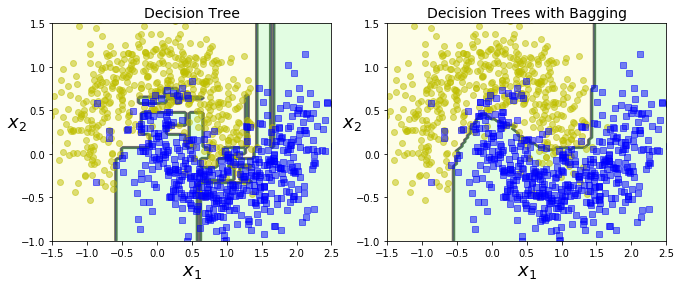

In [32]:
plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree, x, y)
plt.title('Decision Tree', fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, x, y)
plt.title('Decision Trees with Bagging', fontsize=14)
plt.show()

Bagging의 경우 일반화의 성능이 더 뛰어남 (결정경계를 살펴보면)

- Bootstraping은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 bagging이 pasting보다 bias가 조금 더 높음. 하지만 이는 learner들의 상관관계를 줄이므로 앙상블의 분산을 감소시킴
- 전반적으로 bagging을 선호 (bagging과 pasting을 모두 평가해서 더 나은 쪽을 당연히 선택)

## 2.1 oob (out-of-bag)

배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 가능성이 존재한다. BaggingClasiifer는 기본값으로 중복을 허용하여(with replacement) 훈련 세크의 크기 만큼인 m개 샘플을 선택한다. 이는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링된다는 것을 의미한다.
 - m개의 샘플에서 무작위로 하나를 추출할 때 선택되지 않을 확률이 $1-\frac{1}{m}$이고 이를 $m$번 반복했을 때도 선택되지 않을 확률은 $(1-\frac{1}{m})^m$. 로그와 로피탈 정리를 이용하면 $e^{-1}$과 같아진다. 따라서 샘플링될 확률은 $1-e^{-1}$이 된다.
 
여기서 선택되지 않은 훈련 샘플의 나머지 37%를 oob 샘플이라고 한다. 예측기마다 남겨진 37%는 모두 다르다.

따라서 예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 검증 세트나 교차 검증을 사용하지 않고 oob 샘플을 사용하여 평가할 수 있다. 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻는다.

In [35]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True
)

bag_clf.fit(train_x, train_y)
bag_clf.oob_score_  # oob를 이용한 검증 점수

0.9

In [36]:
pred_oob = bag_clf.predict(test_x)
accuracy_score(test_y, pred_oob)

0.912

In [37]:
bag_clf.oob_decision_function_  # oob sample에 대한 결정 함수의 값

array([[0.23157895, 0.76842105],
       [0.30366492, 0.69633508],
       [1.        , 0.        ],
       ...,
       [0.99470899, 0.00529101],
       [0.86363636, 0.13636364],
       [0.        , 1.        ]])